# **AJAYAN G SAROJ**
## *Title: Weather Temperature prediction based on Time Series and LSTM*


[Reference](https://www.tensorflow.org/tutorials/structured_data/time_series)

### [Dataset](https://www.bgc-jena.mpg.de/wetter/)

Dataset contains 14 different features such as air temperature, atmospheric pressure, and humidity. These were collected every 10 minutes we will be only working with the data collected between 2009 and 2016.

In [ ]:
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

# gloabl params for all matplotlib plots
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [ ]:
zip_path = tf.keras.utils.get_file( # 
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)

print(zip_path)

csv_path, _ = os.path.splitext(zip_path) # https://docs.python.org/3/library/os.path.html
print(csv_path)

13582336/13568290 [==============================] - 0s 0us/step
/root/.keras/datasets/jena_climate_2009_2016.csv.zip
/root/.keras/datasets/jena_climate_2009_2016.csv


In [ ]:
! ls /root/.keras/datasets/

jena_climate_2009_2016.csv  jena_climate_2009_2016.csv.zip


In [ ]:
df = pd.read_csv(csv_path)
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


**Observations**:
1. One reading every 10 mins
2. 1 day = 6*24 = 144 readings
3. 5 days = 144*5 = 720 readings

**Forecasting task:**  Predict temperature (in deg C) in the future.





Univariate Analysis

In [ ]:
# Temp vs Time

uni_data_df = df['T (degC)']
uni_data_df.index = df['Date Time']
uni_data_df.head()

Date Time
01.01.2009 00:10:00   -8.02
01.01.2009 00:20:00   -8.41
01.01.2009 00:30:00   -8.51
01.01.2009 00:40:00   -8.31
01.01.2009 00:50:00   -8.27
Name: T (degC), dtype: float64

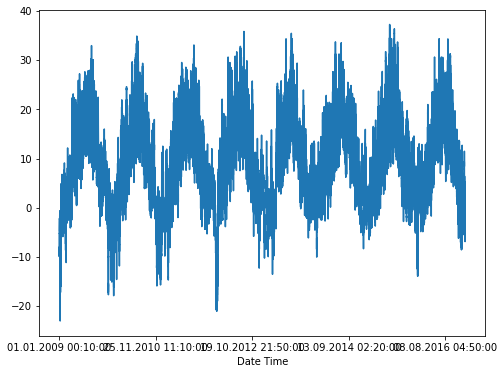

In [ ]:
uni_data_df.plot()

In [ ]:
uni_data = uni_data_df.values # numpy ndarray from pandas

In [ ]:
TRAIN_SPLIT = 300000 # First 300000 obs will be used as train data and rest as test data.
# 300,000 => ~2100 days worth of training data


tf.random.set_seed(13) # random seed 

# Normalize data: mean centering and variance-scaling.
# NOTE: use only train data to normalize all of the data. otherwise, leakage-issue 
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()

uni_data = (uni_data-uni_train_mean)/uni_train_std
print(type(uni_data))

<class 'numpy.ndarray'>


### Moving window average

### Pose a simple problem: 
Using last 'k' values of temperature-observations we will predict the next observation

### MWA: 
By taking average the previous k values we will predict the next value.

In [ ]:
# history_size: k => take k values at a time
# target_size: 0 => next value in the time-series
# Output: data: (n,k) and labels (n,1)

def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)


# Let K= 20 here and use the above function to create the datasets.
univariate_past_history = 20
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

print(x_train_uni.shape)
print(y_train_uni.shape)
print(x_val_uni.shape)
print(y_val_uni.shape)

(299980, 20, 1)
(299980,)
(120531, 20, 1)
(120531,)


In [ ]:
print ('First window of past history')
print (x_train_uni[0])
print ('\n Prediction from first window')
print (y_train_uni[0])

First window of past history
[[-1.99766294]
 [-2.04281897]
 [-2.05439744]
 [-2.0312405 ]
 [-2.02660912]
 [-2.00113649]
 [-1.95134907]
 [-1.95134907]
 [-1.98492663]
 [-2.04513467]
 [-2.08334362]
 [-2.09723778]
 [-2.09376424]
 [-2.09144854]
 [-2.07176515]
 [-2.07176515]
 [-2.07639653]
 [-2.08913285]
 [-2.09260639]
 [-2.10418486]]

 Prediction from first window
-2.1041848598100876


In [ ]:
#utility function
def create_time_steps(length):
  return list(range(-length, 0))
print(create_time_steps(20))

[-20, -19, -18, -17, -16, -15, -14, -13, -12, -11, -10, -9, -8, -7, -6, -5, -4, -3, -2, -1]


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

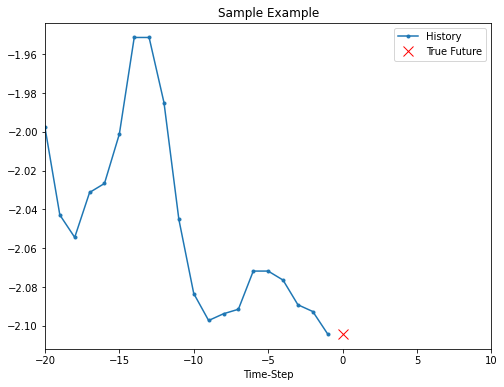

In [ ]:
# Plotting function

# Usage: show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')

def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go'] # dot-line, red-x, green-o  refer: https://matplotlib.org/3.1.1/api/markers_api.html
  time_steps = create_time_steps(plot_data[0].shape[0])
  
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

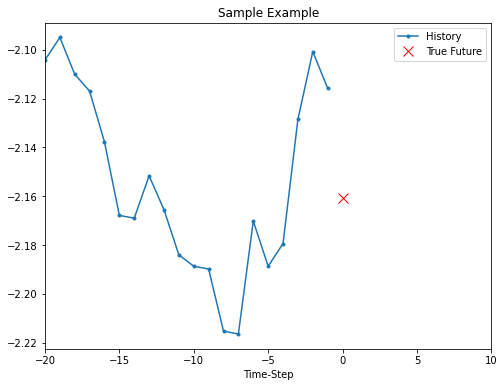

In [ ]:
i=20
show_plot([x_train_uni[i], y_train_uni[i]], 0, 'Sample Example')

In [ ]:
def mwa(history):
  return np.mean(history)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

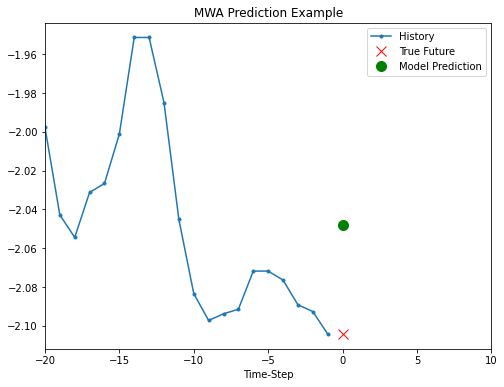

In [ ]:
i=0
show_plot([x_train_uni[i], y_train_uni[i], mwa(x_train_uni[i])], 0,
           'MWA Prediction Example')

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

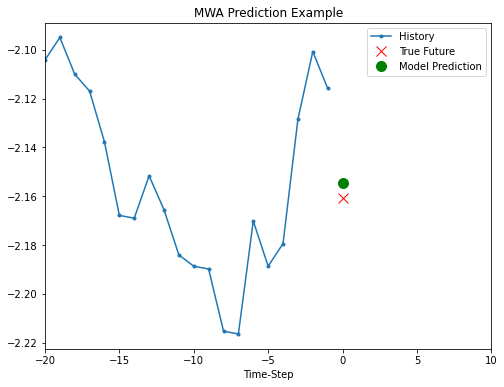

In [ ]:
i=20
show_plot([x_train_uni[i], y_train_uni[i], mwa(x_train_uni[i])], 0,
           'MWA Prediction Example')

### Univariate time-series forecasting

-  Features from the history: Using just the temperature => univariate

- Problem statement: Given last "k=20" values of temp, predict the next temp value.

In [ ]:
# TF Dataset preperation
BATCH_SIZE = 256 # bacth size in batch-SGD/variants
BUFFER_SIZE = 10000 # for shuffling the dataset

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

print(train_univariate)
print(val_univariate)

<RepeatDataset element_spec=(TensorSpec(shape=(None, 20, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>
<RepeatDataset element_spec=(TensorSpec(shape=(None, 20, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>


In [ ]:
# MODEL:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')

In [ ]:
# Train and evaluate
STEPS_PER_EPOCH = 200
EPOCHS = 30

# https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit
simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=STEPS_PER_EPOCH,
                      validation_data=val_univariate, validation_steps=50)

Epoch 1/30
200/200 [==============================] - 8s 7ms/step - loss: 0.4075 - val_loss: 0.1351
Epoch 2/30
200/200 [==============================] - 1s 5ms/step - loss: 0.1118 - val_loss: 0.0360
Epoch 3/30
200/200 [==============================] - 1s 5ms/step - loss: 0.0490 - val_loss: 0.0289
Epoch 4/30
200/200 [==============================] - 1s 5ms/step - loss: 0.0443 - val_loss: 0.0258
Epoch 5/30
200/200 [==============================] - 1s 5ms/step - loss: 0.0299 - val_loss: 0.0235
Epoch 6/30
200/200 [==============================] - 1s 5ms/step - loss: 0.0317 - val_loss: 0.0225
Epoch 7/30
200/200 [==============================] - 1s 5ms/step - loss: 0.0287 - val_loss: 0.0207
Epoch 8/30
200/200 [==============================] - 1s 5ms/step - loss: 0.0263 - val_loss: 0.0200
Epoch 9/30
200/200 [==============================] - 1s 5ms/step - loss: 0.0254 - val_loss: 0.0182
Epoch 10/30
200/200 [==============================] - 1s 5ms/step - loss: 0.0228 - val_loss: 0.0174

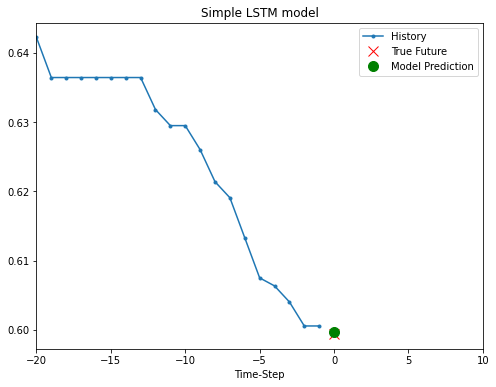

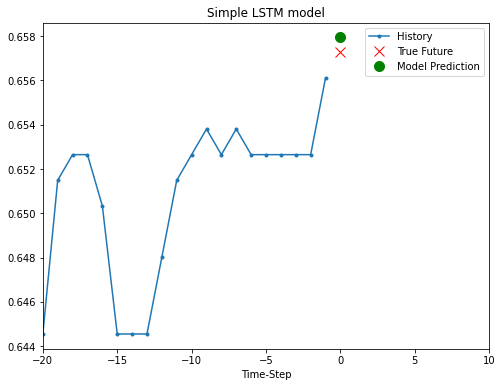

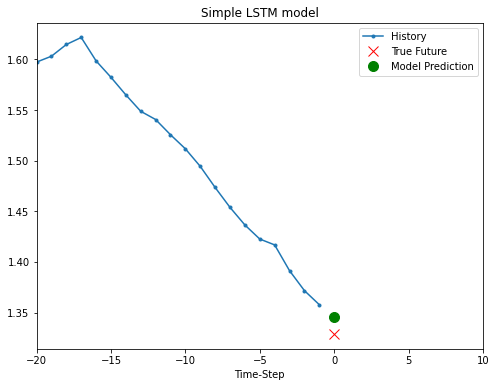

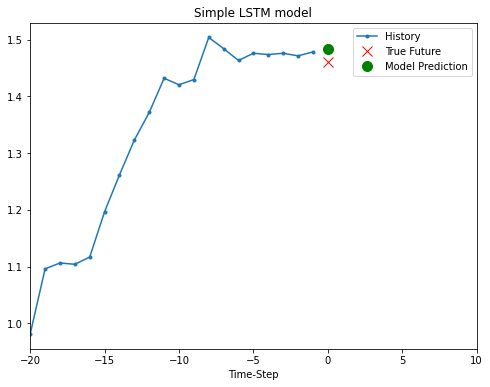

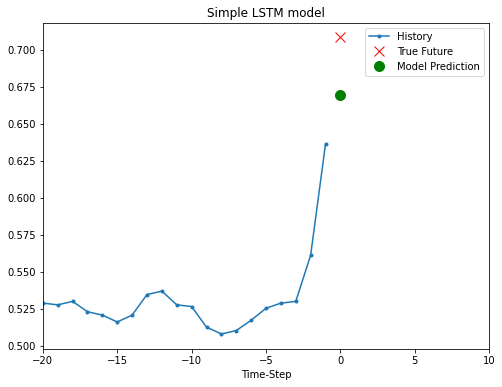

In [ ]:

for x, y in val_univariate.take(5): # take 5 random inputs from validation data
  plot = show_plot([x[0].numpy(), y[0].numpy(),
                    simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
  plot.show()

### Multi-variate & single-step forecasting

- Problem Statement: From features (p, T, rho) at each time stamp in the past, predict the temperature at a single time-stamp in the future.

In [ ]:
# Features
features_considered = ['p (mbar)', 'T (degC)', 'rho (g/m**3)']
features = df[features_considered]
features.index = df['Date Time']
features.head()

,p (mbar),T (degC),rho (g/m**3)
Date Time,,,
01.01.2009 00:10:00,996.52,-8.02,1307.75
01.01.2009 00:20:00,996.57,-8.41,1309.80
01.01.2009 00:30:00,996.53,-8.51,1310.24
01.01.2009 00:40:00,996.51,-8.31,1309.19
01.01.2009 00:50:00,996.51,-8.27,1309.00


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fba8d586e50>,
      dtype=object)

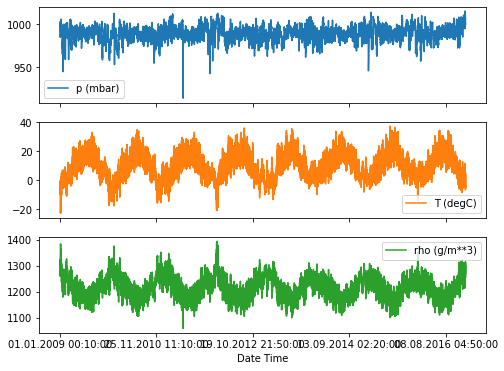

In [ ]:
features.plot(subplots=True)

In [ ]:
# Standardize data

dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)
dataset = (dataset-data_mean)/data_std  # standard-scaling

In [ ]:
# step: instead of taking data for each 10min,here we generate data once every 6 steps (60min)

def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step: # single_step used here.
      labels.append(target[i+target_size]) 
    else:
      labels.append(target[i:i+target_size]) 

  return np.array(data), np.array(labels)

In [ ]:
# Generate data
past_history = 720 # 720*10 mins 
future_target = 72 # 72*10 mins
STEP = 6 # one obs every 6X10min = 60 min => 1 hr

x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 1], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 1],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

print(x_train_single.shape)
print(y_train_single.shape)

(299280, 120, 3)
(299280,)


In [ ]:
# Using TF data

train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

print(train_data_single)
print(val_data_single)

<RepeatDataset element_spec=(TensorSpec(shape=(None, 120, 3), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>
<RepeatDataset element_spec=(TensorSpec(shape=(None, 120, 3), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>


In [ ]:
# Model
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(32,
                                           input_shape=x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(1))

single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')

single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=STEPS_PER_EPOCH,
                                            validation_data=val_data_single,
                                            validation_steps=50)

Epoch 1/30
200/200 [==============================] - 7s 20ms/step - loss: 0.3090 - val_loss: 0.2646
Epoch 2/30
200/200 [==============================] - 3s 17ms/step - loss: 0.2623 - val_loss: 0.2431
Epoch 3/30
200/200 [==============================] - 3s 16ms/step - loss: 0.2613 - val_loss: 0.2474
Epoch 4/30
200/200 [==============================] - 3s 16ms/step - loss: 0.2567 - val_loss: 0.2447
Epoch 5/30
200/200 [==============================] - 2s 10ms/step - loss: 0.2262 - val_loss: 0.2356
Epoch 6/30
200/200 [==============================] - 2s 10ms/step - loss: 0.2413 - val_loss: 0.2680
Epoch 7/30
200/200 [==============================] - 2s 9ms/step - loss: 0.2403 - val_loss: 0.2533
Epoch 8/30
200/200 [==============================] - 2s 9ms/step - loss: 0.2392 - val_loss: 0.2385
Epoch 9/30
200/200 [==============================] - 2s 10ms/step - loss: 0.2448 - val_loss: 0.2459
Epoch 10/30
200/200 [==============================] - 2s 11ms/step - loss: 0.2379 - val_loss

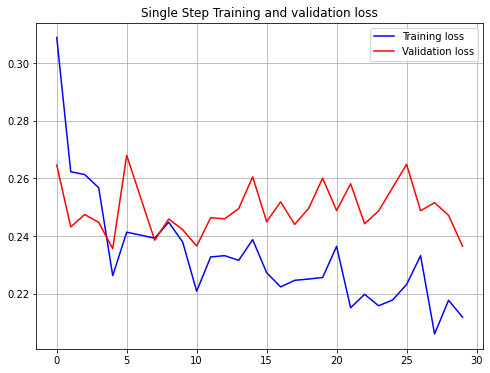

In [ ]:
# Plotting train and validation loss over epochs

def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()
  plt.grid()

  plt.show()



plot_train_history(single_step_history,'Single Step Training and validation loss')

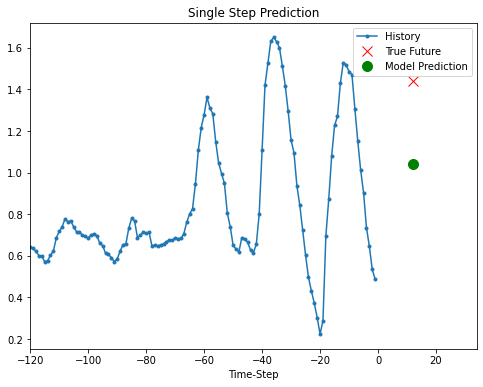

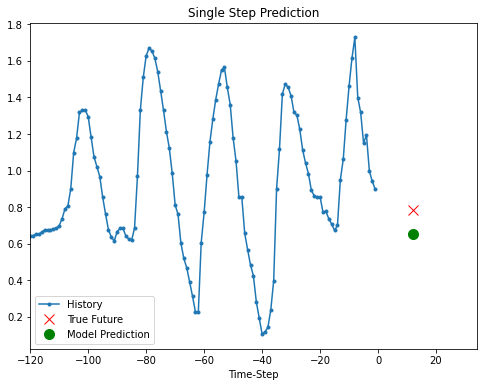

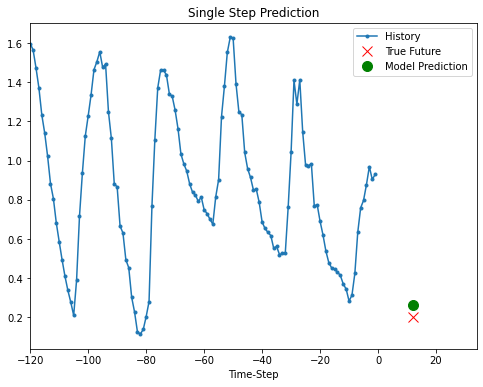

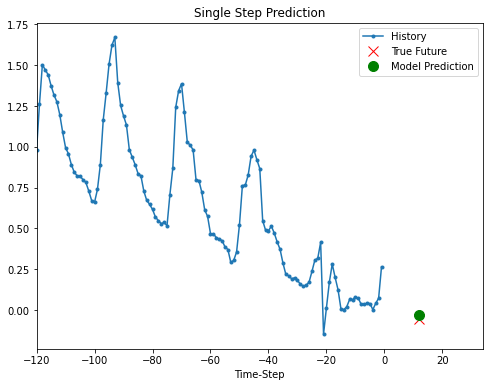

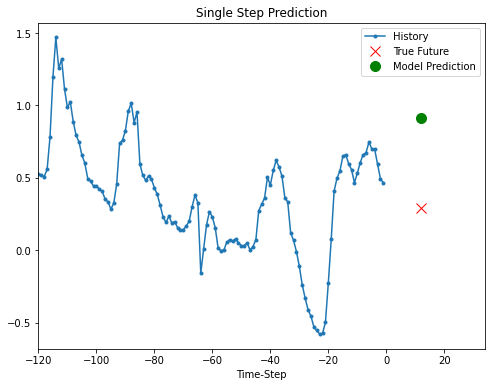

In [ ]:
# Time series and predicted values

for x, y in val_data_single.take(5):
  plot = show_plot([x[0][:, 1].numpy(), y[0].numpy(),
                    single_step_model.predict(x)[0]], 12,
                   'Single Step Prediction')
  plot.show()


### Multi-variate & multi-step forecasting
- Generate multiple future values of temperature

In [ ]:
# single_step=FALSE ---> We predict more than 1 values of output

future_target = 72 # predict upcoming 72 future values
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 1], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 1],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

print(x_train_multi.shape)
print(y_train_multi.shape)
print(x_val_multi.shape)
print(y_val_multi.shape)

(299280, 120, 3)
(299280, 72)
(119759, 120, 3)
(119759, 72)


In [ ]:
# Tensor converted dataset

train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

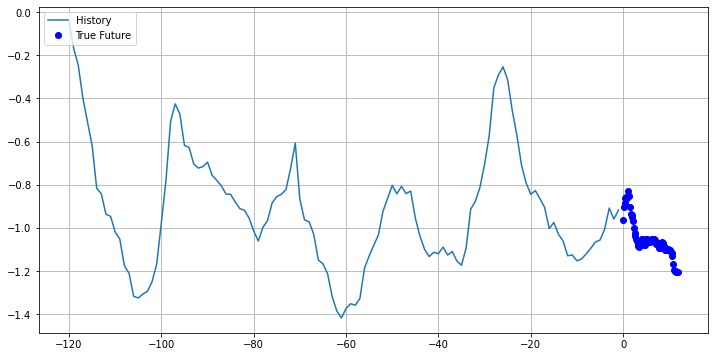

In [ ]:
#plotting function
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)
  plt.grid()
  plt.plot(num_in, np.array(history[:, 1]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()  

for x, y in train_data_multi.take(1):
  multi_step_plot(x[0], y[0], np.array([0]))

In [ ]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(72)) # for 72 outputs

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=STEPS_PER_EPOCH,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

Epoch 1/30
200/200 [==============================] - 46s 216ms/step - loss: 0.4952 - val_loss: 0.3047
Epoch 2/30
200/200 [==============================] - 44s 219ms/step - loss: 0.3474 - val_loss: 0.2902
Epoch 3/30
200/200 [==============================] - 43s 217ms/step - loss: 0.3295 - val_loss: 0.2513
Epoch 4/30
200/200 [==============================] - 42s 212ms/step - loss: 0.2434 - val_loss: 0.2086
Epoch 5/30
200/200 [==============================] - 47s 236ms/step - loss: 0.1966 - val_loss: 0.1992
Epoch 6/30
200/200 [==============================] - 43s 213ms/step - loss: 0.2068 - val_loss: 0.2123
Epoch 7/30
200/200 [==============================] - 44s 222ms/step - loss: 0.1982 - val_loss: 0.2043
Epoch 8/30
200/200 [==============================] - 42s 211ms/step - loss: 0.1959 - val_loss: 0.2033
Epoch 9/30
200/200 [==============================] - 42s 210ms/step - loss: 0.1983 - val_loss: 0.1886
Epoch 10/30
200/200 [==============================] - 43s 213ms/step - l

In [ ]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')


In [ ]:
for x, y in val_data_multi.take(3):
  multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])